In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS
from utils import wandb_to_beaker_result, beaker_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS["10yr-with-precip"]
beaker_dataset_id = wandb_to_beaker_result("ace", wandb_id)
variables = ['PRATEsfc']

In [3]:
beaker_dataset_id

'01J729FFPJN8B2AEQ9QKR3FDBJ'

### Load data and take daily means

In [4]:
ds_pred = beaker_to_xarray(beaker_dataset_id, "autoregressive_predictions.nc")
ds_pred = ds_pred.isel(sample=0)
ds_pred = ds_pred[variables]
ds_pred['time'] = ds_pred['valid_time']
ds_pred = ds_pred.resample(time='1D').mean()

#ds_pred = ds_pred.sel(time=slice('2003', '2008'))

ds_target = beaker_to_xarray(beaker_dataset_id, "autoregressive_target.nc")
ds_target = ds_target.isel(sample=0)
ds_target = ds_target[variables]
ds_target['time'] = ds_target['valid_time']
ds_target = ds_target.resample(time='1D').mean()
#ds_target = ds_target.sel(time=slice('2003', '2008'))

Output()

Output()

In [5]:
da = xr.concat(
    [
        (86400*ds_target.PRATEsfc).assign_coords(source="ERA5"),
        (86400*ds_pred.PRATEsfc).assign_coords(source="ACE2-ERA5")
    ],
    dim="source"
)
da.attrs['units'] = 'mm/day'

In [6]:
tropical_precip = da.sel(lat=slice(-10, 10)).mean('lat')
tropical_precip.attrs['long_name'] = 'Daily mean precipitation rate averaged from 10°S to 10°N'

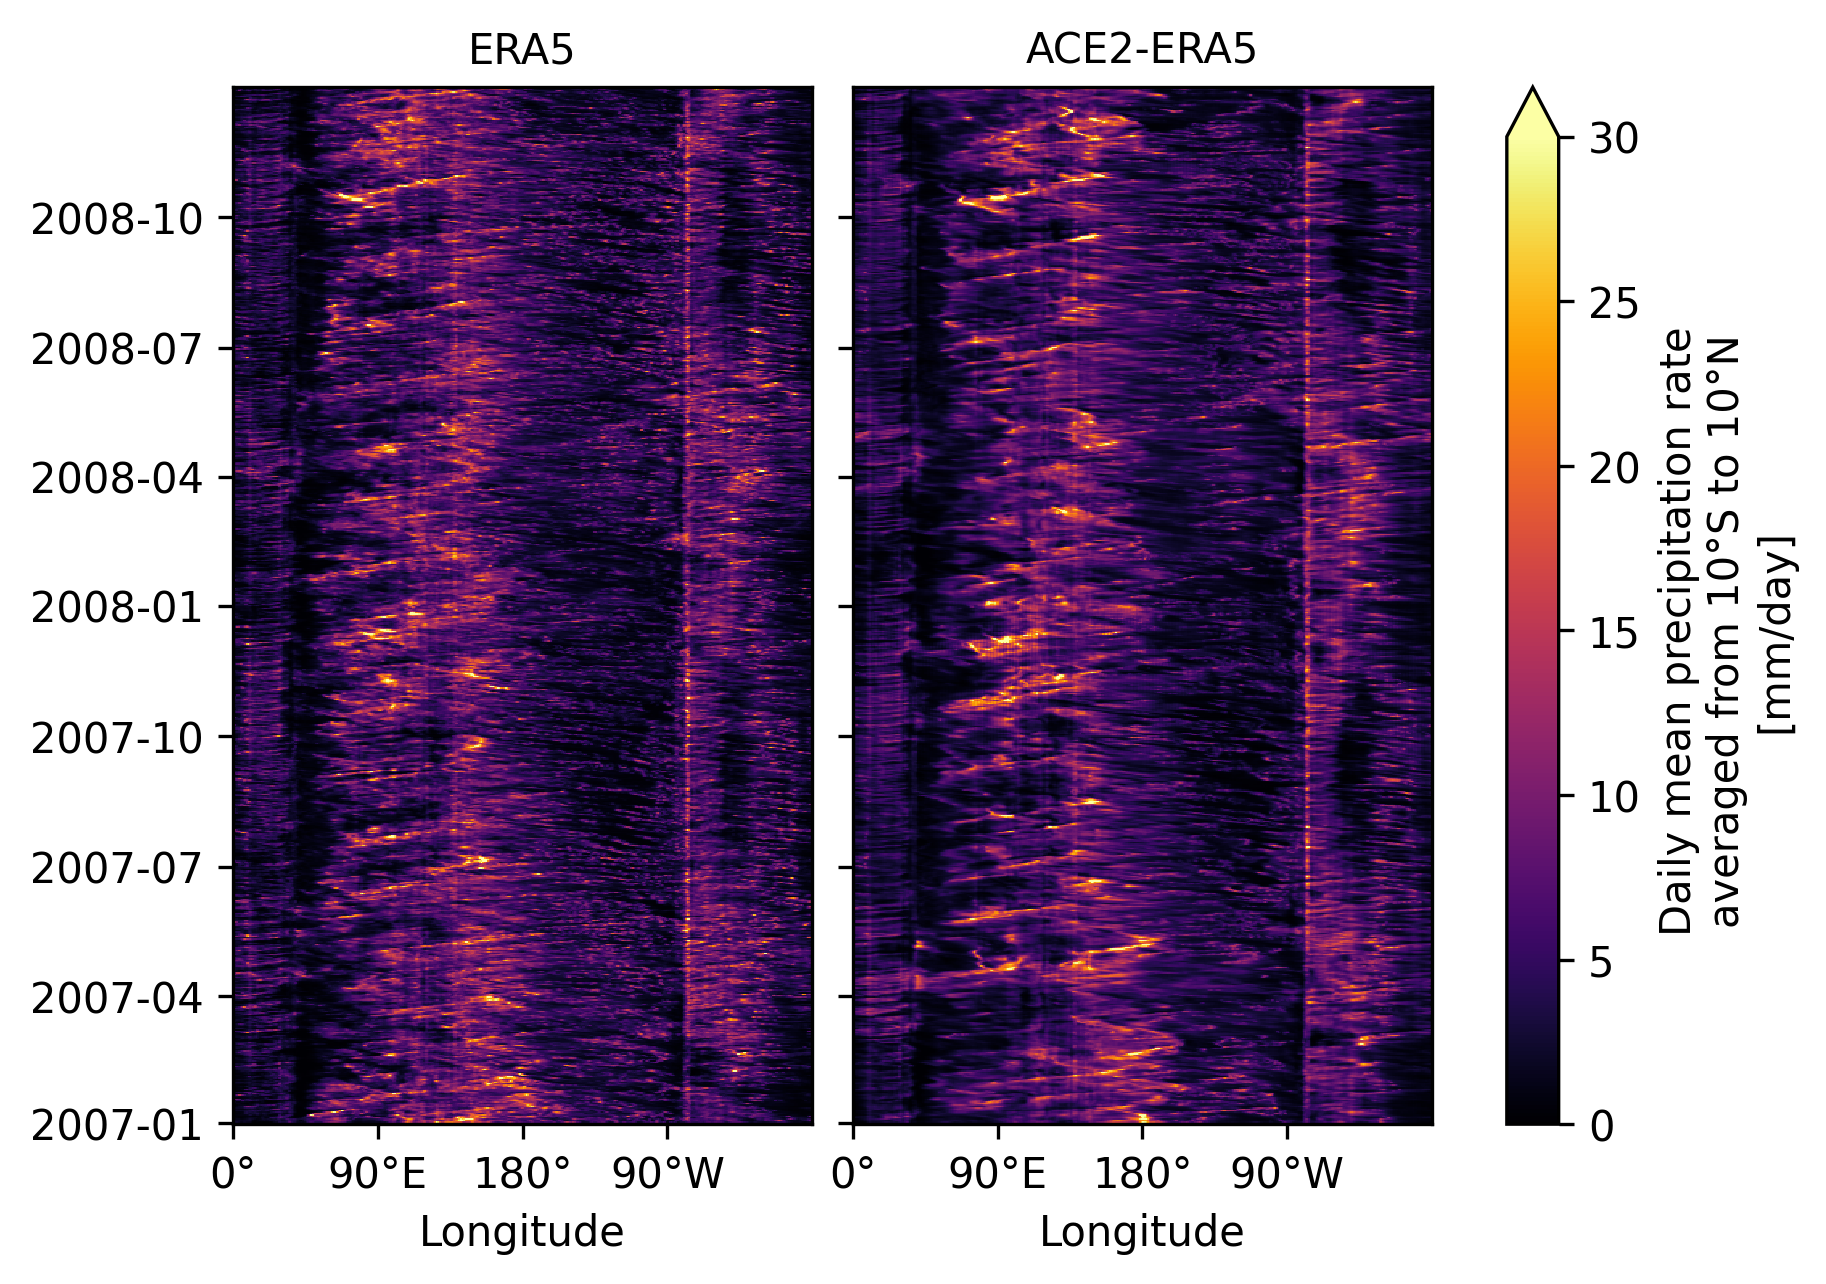

In [7]:
fg = tropical_precip.sel(time=slice('2007', '2008')).plot(y='time', col='source', vmin=0, vmax=30, cmap='inferno')
fg.fig.set_size_inches((6, 5))
fg.set_titles(template='{value}')
fg.set_ylabels('')
fg.set_xlabels('Longitude')
for ax in fg.axs.flat:
    ax.set_xticks([0, 90, 180, 270], labels=['0°', '90°E', '180°', '90°W'])
fg.fig.savefig('figures/era5_daily_tropical_precip.png', bbox_inches='tight', transparent=True, dpi=300)


In [8]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=1)
    return y

In [9]:
low_period = 20  # in days
high_period = 100
filtered = tropical_precip.copy(deep=True)
filtered.values = butter_bandpass_filter(tropical_precip, 1/high_period, 1/low_period, 1.0)
filtered.attrs['long_name'] = f"{low_period}-{high_period} day bandpass filtered precipitation rate averaged from 10°S to 10°N"

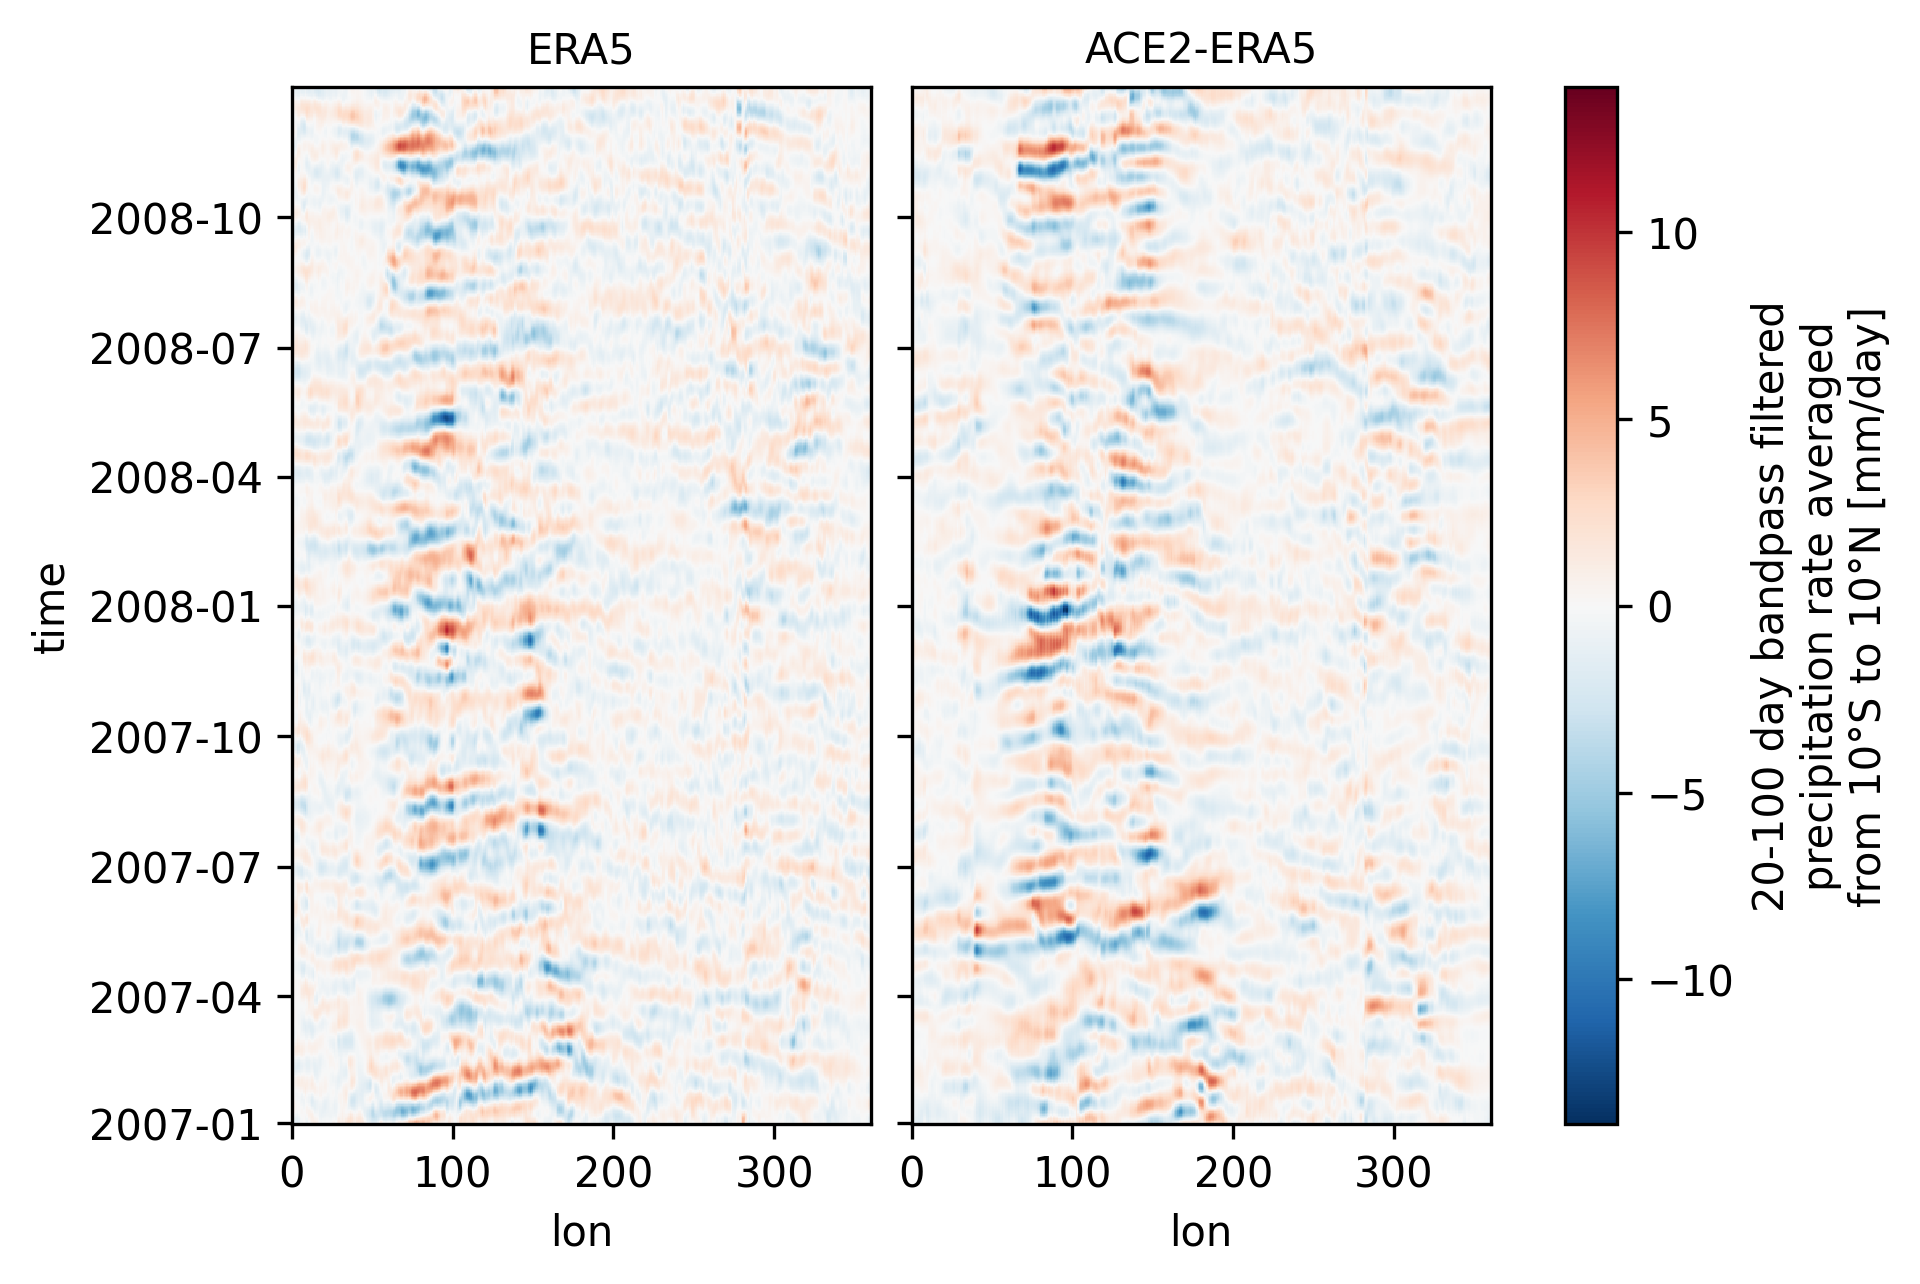

In [10]:
fg = filtered.sel(time=slice('2007', '2008')).plot(col='source')
fg.fig.set_size_inches((6, 5))
fg.set_titles(template='{value}')

In [11]:
def compute_lag_correlation(da, lon_slice):
    lag_correlations = []
    for day in range(-30, 31):
        x = da.sel(lon=lon_slice).mean('lon').shift(time=day)
        y = da
        lag_corr = xr.corr(x, y, dim='time')
        lag_correlations.append(lag_corr.assign_coords(lag=day))
    lag_correlations = xr.concat(lag_correlations, dim='lag')
    lag_correlations['lag'].attrs['units'] = 'days'
    lon_label = f'{lon_slice.start}°E-{lon_slice.stop}°E'
    lag_correlations.attrs['long_name'] = f'Lag correlation on precipitation at {lon_label}'
    return lag_correlations

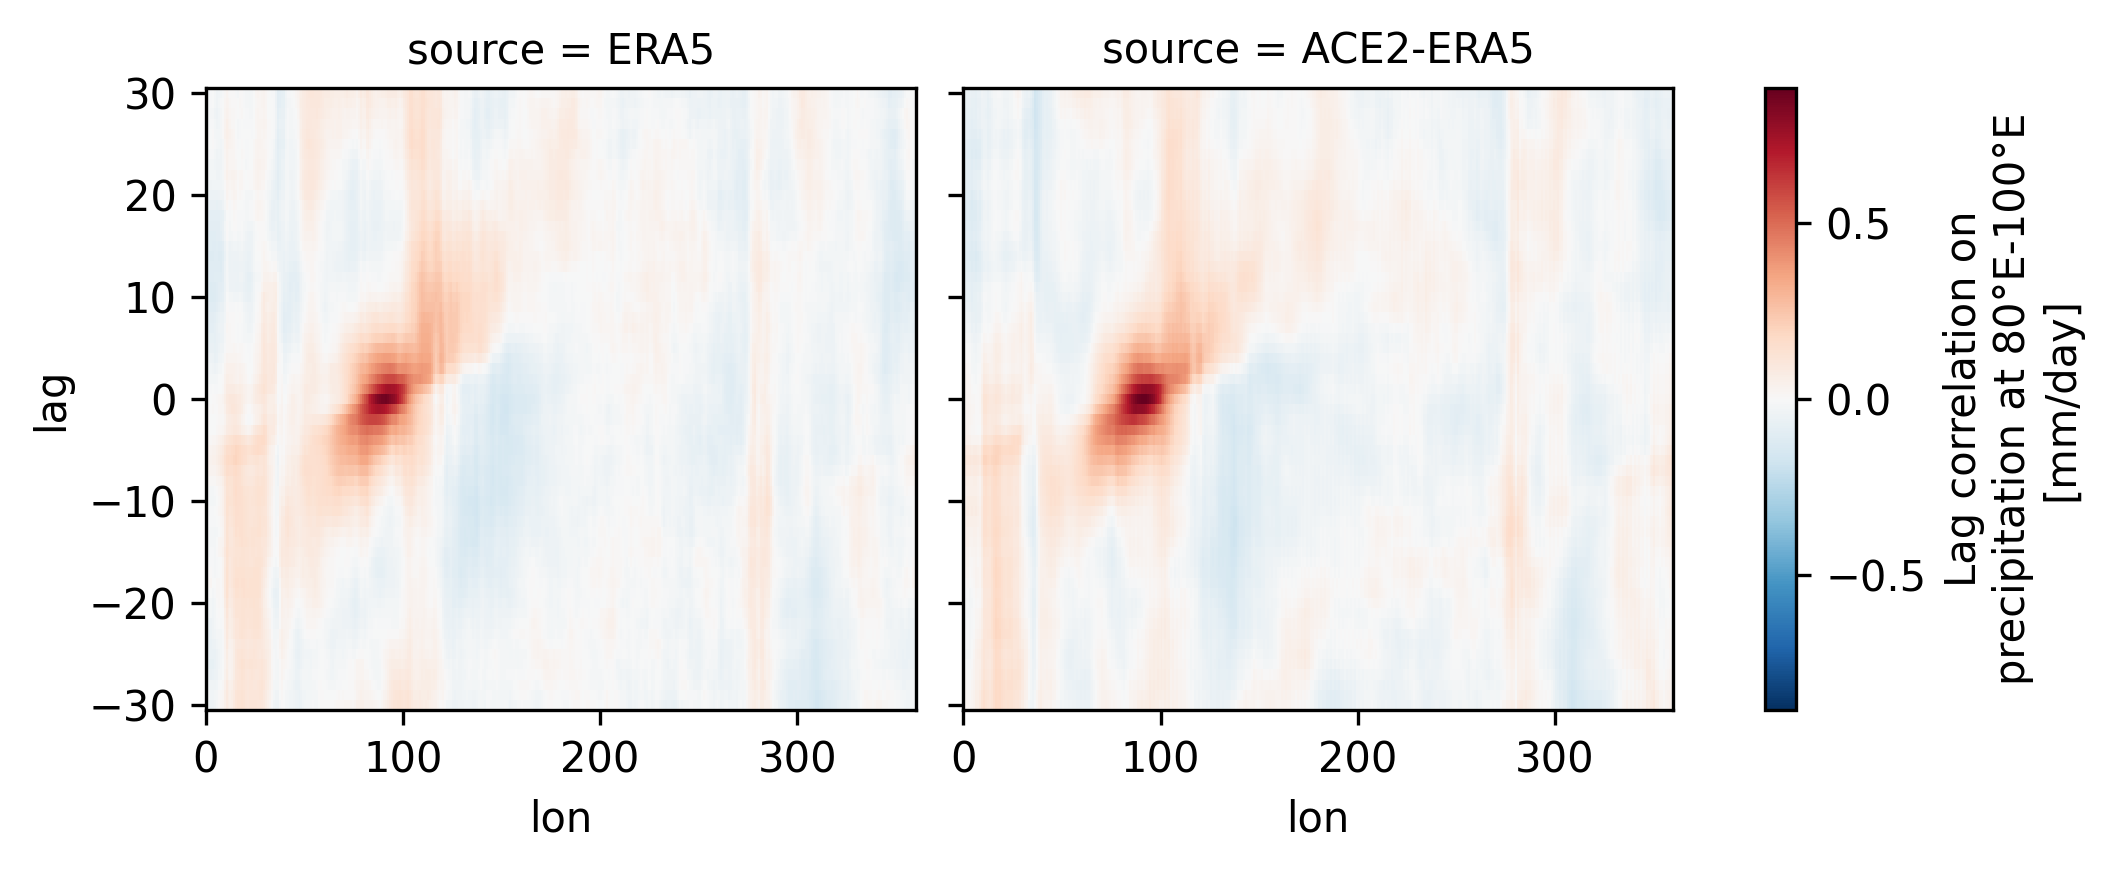

In [12]:
lag_correlations = compute_lag_correlation(tropical_precip, slice(80, 100))
lag_correlations.plot(col='source')

In [13]:
lag_correlations

<xarray.DataArray 'PRATEsfc' (lag: 61, source: 2, lon: 360)> Size: 351kB
array([[[-0.02960196, -0.04165012, -0.05073012, ..., -0.02726515,
         -0.02333781, -0.0250236 ],
        [ 0.04216919,  0.0256425 ,  0.02124727, ...,  0.03140995,
          0.04312916,  0.03951543]],

       [[-0.00575359, -0.01745531, -0.03393393, ..., -0.01999683,
         -0.01352563, -0.01031386],
        [ 0.03489025,  0.01762576,  0.01121818, ...,  0.03654959,
          0.04341193,  0.03476737]],

       [[-0.01497395, -0.02777197, -0.03919733, ..., -0.02633969,
         -0.02286479, -0.01884854],
        [ 0.02653967,  0.01078073,  0.00553911, ...,  0.0320385 ,
          0.03781251,  0.02715963]],

       ...,

       [[-0.0155461 , -0.01963049, -0.01582513, ..., -0.00347527,
         -0.00618042, -0.00622438],
        [-0.07589809, -0.07840147, -0.07413646, ..., -0.065515  ,
         -0.06558652, -0.06007957]],

       [[-0.02224044, -0.02027942, -0.01062934, ..., -0.00546271,
         -0.01051855, -0.01699677],
        [-0.06874796, -0.07209442, -0.06873085, ..., -0.06195165,
         -0.05945191, -0.0522618 ]],

       [[-0.0199021 , -0.02386496, -0.01254644, ..., -0.002525  ,
         -0.00257774, -0.00692153],
        [-0.05950184, -0.0644189 , -0.0615511 , ..., -0.04946893,
         -0.04843117, -0.04252772]]])
Coordinates:
    init_time  datetime64[ns] 8B 2001-01-01T06:00:00
  * source     (source) <U9 72B 'ERA5' 'ACE2-ERA5'
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lag        (lag) int64 488B -30 -29 -28 -27 -26 -25 ... 25 26 27 28 29 30
Attributes:
    units:      mm/day
    long_name:  Lag correlation on precipitation at 80°E-100°E

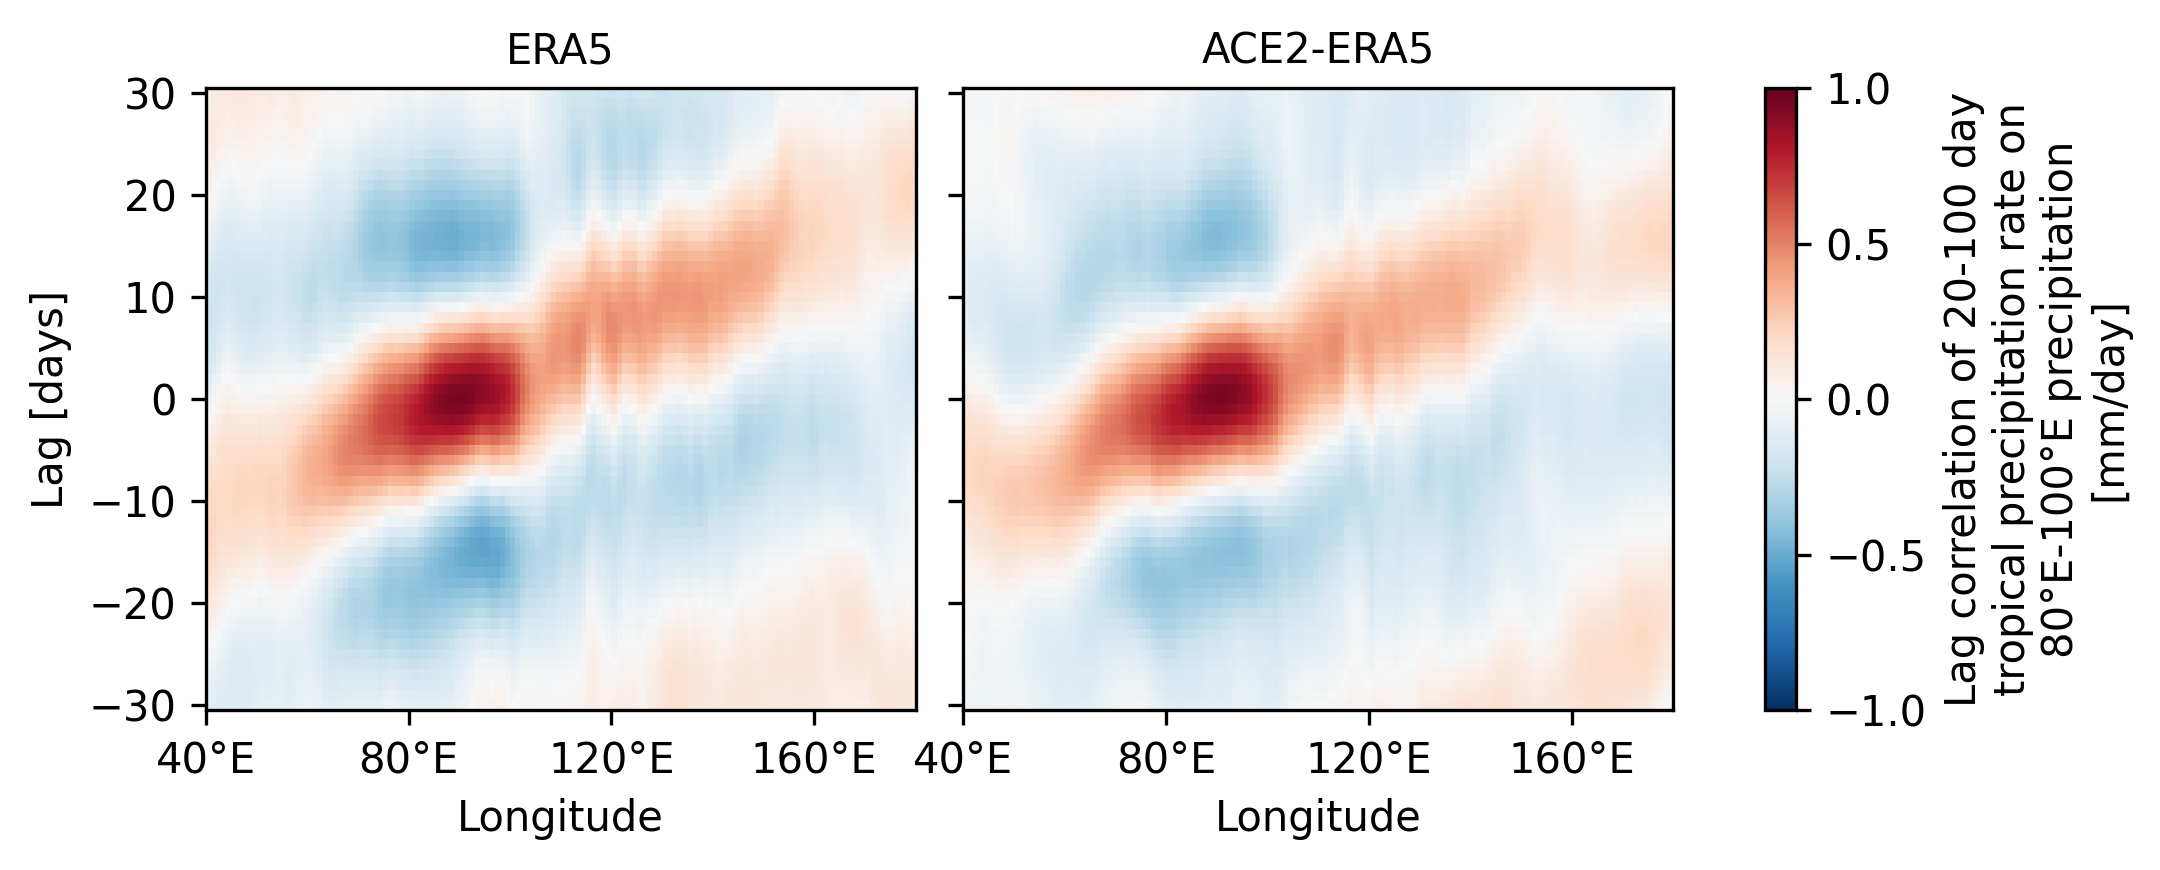

In [14]:
lag_correlations = compute_lag_correlation(filtered, slice(80, 100))
lag_correlations.attrs['long_name'] = 'Lag correlation of 20-100 day tropical precipitation rate on 80°E-100°E precipitation'
fg = lag_correlations.plot(col='source', xlim=[40, 180], vmin=-1, vmax=1, cmap='RdBu_r')
fg.set_ylabels('Lag [days]')
fg.set_xlabels('Longitude')
for ax in fg.axs.flat:
    ax.set_xticks([40, 80, 120, 160], labels=['40°E', '80°E', '120°E', '160°E'])
fg.set_titles(template='{value}')
fg.fig.savefig('figures/era5_tropical_precip_lag_correlation.png', bbox_inches='tight', transparent=True, dpi=300)